In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Input, Bidirectional, LSTM, TimeDistributed, RNN, BatchNormalization
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import shutil
import cv2
import os

print ('Library loaded')

Library loaded


In [2]:
train_path = '/kaggle/input/penyakit-paru-paru-5-kelas/train_dir'
test_path = '/kaggle/input/penyakit-paru-paru-5-kelas/test_dir'

batch_size = 16
val_batch_size = 8

image_size = 224

## ResNet50

In [3]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=val_batch_size,
                                           shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [4]:
base_model_resnet50 = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_resnet50.layers:
    layer.trainable = False

94781440/94765736 [==============================] - 0s 0us/step


In [5]:
model_resnet50 = Sequential()
model_resnet50.add(base_model_resnet50)
model_resnet50.add(TimeDistributed(Flatten()))
model_resnet50.add(Bidirectional(LSTM(128, activation='relu', return_sequences= True)))
model_resnet50.add(Bidirectional(LSTM(16, activation='relu', return_sequences= True)))
model_resnet50.add(Dropout(0.2))
model_resnet50.add(Dense(128, activation='relu'))
model_resnet50.add(Dense(16, activation='relu'))
model_resnet50.add(Dropout(0.2))
model_resnet50.add(Flatten())
model_resnet50.add(Dense(5, activation="softmax"))
model_resnet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 14336)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 7, 256)            14812160  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 7, 32)             34944     
_________________________________________________________________
dropout (Dropout)            (None, 7, 32)             0         
_________________________________________________________________
dense (Dense)                (None, 7, 128)            4224      
_________________________________________________________________
dense_1 (Dense)              (None, 7, 16)             2

In [6]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=1e-6,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

In [7]:
model_resnet50.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history_resnet50 = model_resnet50.fit(train_batches, 
                                      validation_data=test_batches, 
                                      epochs=30, 
                                      verbose=1, 
                                      callbacks=[early_stopping, reduce_lr])

Epoch 1/30
380/380 [==============================] - 80s 171ms/step - loss: 0.8721 - acc: 0.6584 - val_loss: 0.4637 - val_acc: 0.8605
Epoch 2/30
380/380 [==============================] - 41s 108ms/step - loss: 0.4813 - acc: 0.8322 - val_loss: 0.2851 - val_acc: 0.9084
Epoch 3/30
380/380 [==============================] - 41s 108ms/step - loss: 0.2717 - acc: 0.9030 - val_loss: 0.2166 - val_acc: 0.9318
Epoch 4/30
380/380 [==============================] - 41s 107ms/step - loss: 0.1918 - acc: 0.9344 - val_loss: 0.2480 - val_acc: 0.9379
Epoch 5/30
380/380 [==============================] - 41s 107ms/step - loss: 0.1768 - acc: 0.9416 - val_loss: 0.2621 - val_acc: 0.9348
Epoch 6/30
380/380 [==============================] - 41s 108ms/step - loss: 0.1389 - acc: 0.9572 - val_loss: 0.2347 - val_acc: 0.9501
Epoch 7/30
380/380 [==============================] - 41s 108ms/step - loss: 0.1162 - acc: 0.9648 - val_loss: 0.2310 - val_acc: 0.9470
Epoch 8/30
380/380 [==============================] - 4

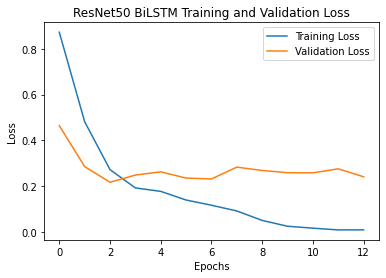

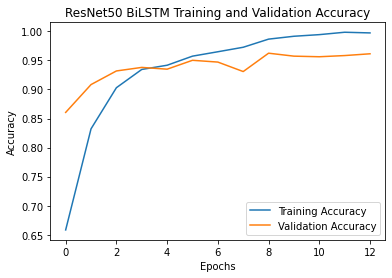

In [8]:
# Plot loss
plt.plot(history_resnet50.history['loss'], label='Training Loss')
plt.plot(history_resnet50.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_resnet50.history['acc'], label='Training Accuracy')
plt.plot(history_resnet50.history['val_acc'], label='Validation Accuracy')
plt.title('ResNet50 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
train_score = model_resnet50.evaluate(train_batches, verbose=1)
test_score = model_resnet50.evaluate(test_batches, verbose=1)

123/123 [==============================] - 6s 46ms/step - loss: 0.2166 - acc: 0.9318


In [10]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
123/123 [==============================] - 7s 47ms/step

Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.89048   0.90777   0.89904       206
            covid19    0.95694   0.94787   0.95238       211
             normal    0.96535   0.93301   0.94891       209
       tuberculosis    0.98582   0.99286   0.98932       140
    viral_pneumonia    0.88182   0.89815   0.88991       216

           accuracy                        0.93177       982
          macro avg    0.93608   0.93593   0.93591       982
       weighted avg    0.93238   0.93177   0.93198       982



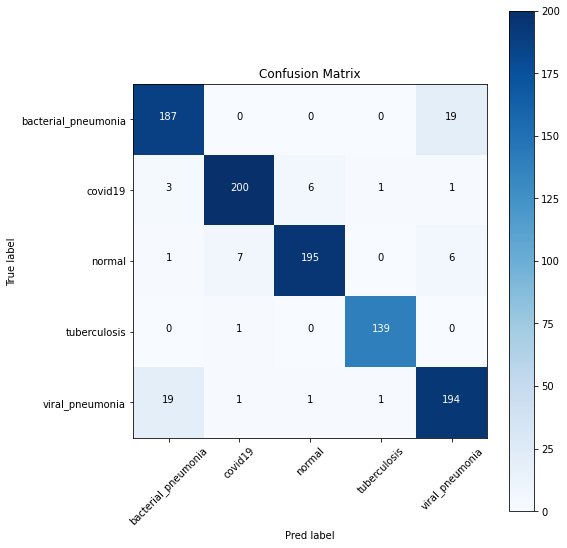

In [11]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_resnet50.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [12]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
380/380 [==============================] - 30s 78ms/step

Training Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.96160   0.92377   0.94231      1220
            covid19    0.97910   0.94208   0.96023      1243
             normal    0.93031   0.96194   0.94586      1235
       tuberculosis    0.98046   0.98632   0.98338      1170
    viral_pneumonia    0.91812   0.95297   0.93522      1212

           accuracy                        0.95312      6080
          macro avg    0.95392   0.95342   0.95340      6080
       weighted avg    0.95378   0.95312   0.95319      6080



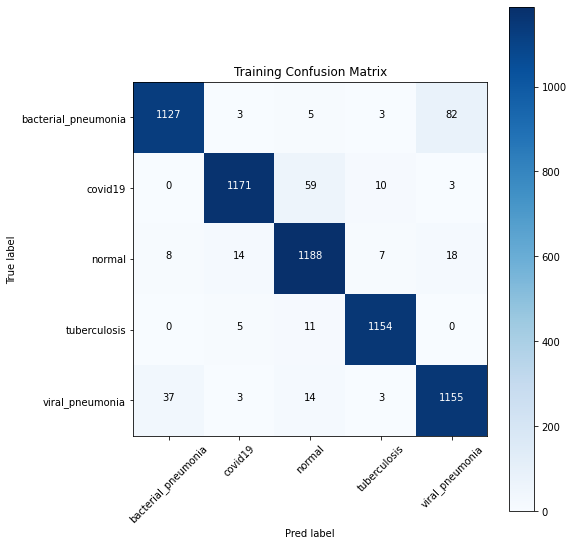

In [13]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_resnet50.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## VGG19

In [14]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size,shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [15]:
base_model_vgg19 = tf.keras.applications.VGG19(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_vgg19.layers:
    layer.trainable = False

80150528/80134624 [==============================] - 0s 0us/step


In [16]:
model_vgg19 = Sequential()
model_vgg19.add(base_model_vgg19)
model_vgg19.add(TimeDistributed(Flatten()))
model_vgg19.add(Bidirectional(LSTM(128, activation='relu', return_sequences= True)))
model_vgg19.add(Bidirectional(LSTM(16, activation='relu', return_sequences= True)))
model_vgg19.add(Dropout(0.2))
model_vgg19.add(Dense(128, activation='relu'))
model_vgg19.add(Dense(16, activation='relu'))
model_vgg19.add(Dropout(0.2))
model_vgg19.add(Flatten())
model_vgg19.add(Dense(5, activation="softmax"))

model_vgg19.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 3584)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 7, 256)            3802112   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 7, 32)             34944     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 32)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 7, 128)            4224      
_________________________________________________________________
dense_4 (Dense)              (None, 7, 16)            

In [17]:
model_vgg19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history_vgg19 = model_vgg19.fit(train_batches, 
                                validation_data=test_batches, 
                                epochs=30, 
                                verbose=1, 
                                callbacks=[early_stopping, 
                                           reduce_lr])

Epoch 1/30
380/380 [==============================] - 55s 125ms/step - loss: 1.7597 - acc: 0.2719 - val_loss: 1.5122 - val_acc: 0.3768
Epoch 2/30
380/380 [==============================] - 43s 113ms/step - loss: 1.3888 - acc: 0.4192 - val_loss: 1.2809 - val_acc: 0.5143
Epoch 3/30
380/380 [==============================] - 43s 113ms/step - loss: 1.1424 - acc: 0.5546 - val_loss: 1.0974 - val_acc: 0.6100
Epoch 4/30
380/380 [==============================] - 43s 113ms/step - loss: 0.9402 - acc: 0.6424 - val_loss: 0.9207 - val_acc: 0.6690
Epoch 5/30
380/380 [==============================] - 43s 113ms/step - loss: 0.7734 - acc: 0.7171 - val_loss: 0.8428 - val_acc: 0.6894
Epoch 6/30
380/380 [==============================] - 43s 113ms/step - loss: 0.6435 - acc: 0.7559 - val_loss: 0.8230 - val_acc: 0.6955
Epoch 7/30
380/380 [==============================] - 43s 113ms/step - loss: 0.5339 - acc: 0.8081 - val_loss: 0.7665 - val_acc: 0.7179
Epoch 8/30
380/380 [==============================] - 4

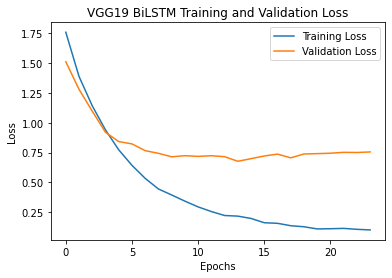

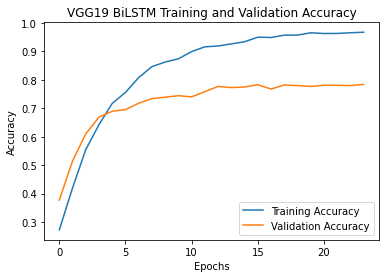

In [18]:
# Plot loss
plt.plot(history_vgg19.history['loss'], label='Training Loss')
plt.plot(history_vgg19.history['val_loss'], label='Validation Loss')
plt.title('VGG19 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_vgg19.history['acc'], label='Training Accuracy')
plt.plot(history_vgg19.history['val_acc'], label='Validation Accuracy')
plt.title('VGG19 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
train_score = model_vgg19.evaluate(train_batches, verbose=1)
test_score = model_vgg19.evaluate(test_batches, verbose=1)

123/123 [==============================] - 8s 64ms/step - loss: 0.6774 - acc: 0.7729


In [20]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
123/123 [==============================] - 9s 63ms/step

Classification Report VGG19:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.70892   0.73301   0.72076       206
            covid19    0.82474   0.75829   0.79012       211
             normal    0.77826   0.85646   0.81549       209
       tuberculosis    0.87591   0.85714   0.86643       140
    viral_pneumonia    0.71635   0.68981   0.70283       216

           accuracy                        0.77291       982
          macro avg    0.78084   0.77894   0.77913       982
       weighted avg    0.77401   0.77291   0.77265       982



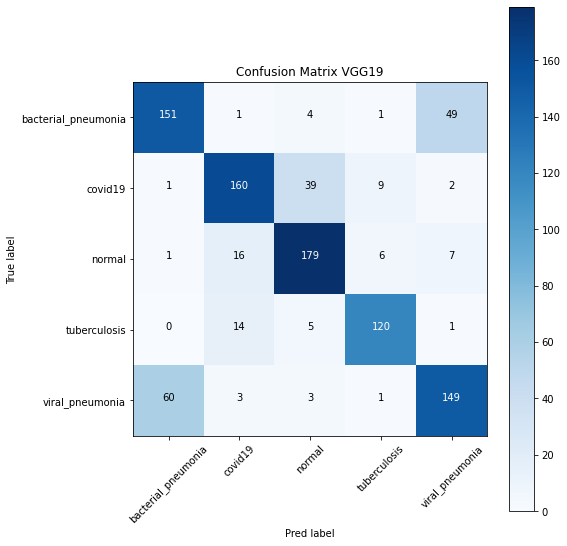

In [21]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_vgg19.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report VGG19:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix VGG19")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [22]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
380/380 [==============================] - 34s 89ms/step

Training Classification Report VGG19:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.99262   0.99262   0.99262      1220
            covid19    0.99436   0.99276   0.99356      1243
             normal    0.98631   0.99190   0.98910      1235
       tuberculosis    0.99914   0.98889   0.99399      1170
    viral_pneumonia    0.98769   0.99340   0.99054      1212

           accuracy                        0.99194      6080
          macro avg    0.99203   0.99191   0.99196      6080
       weighted avg    0.99197   0.99194   0.99195      6080



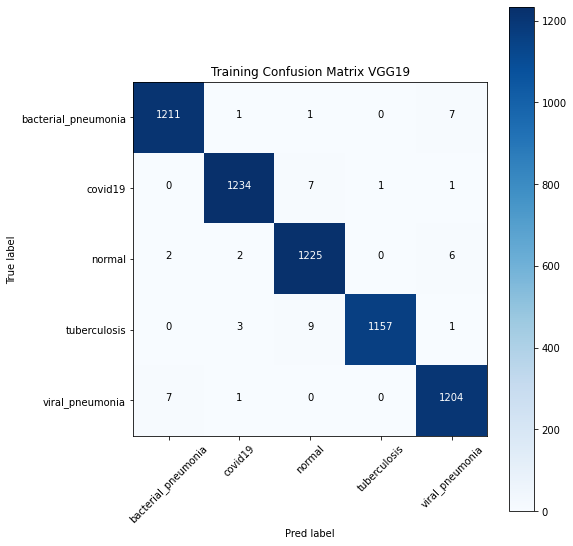

In [23]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_vgg19.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report VGG19:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix VGG19")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## InceptionV3

In [24]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size,shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [25]:
base_model_inceptionv3 = tf.keras.applications.InceptionV3(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_inceptionv3.layers:
    layer.trainable = False

87924736/87910968 [==============================] - 0s 0us/step


In [26]:
model_inceptionv3 = Sequential()
model_inceptionv3.add(base_model_inceptionv3)
model_inceptionv3.add(TimeDistributed(Flatten()))
model_inceptionv3.add(Bidirectional(LSTM(128, activation='relu', return_sequences= True)))
model_inceptionv3.add(Bidirectional(LSTM(16, activation='relu', return_sequences= True)))
model_inceptionv3.add(Dropout(0.2))
model_inceptionv3.add(Dense(128, activation='relu'))
model_inceptionv3.add(Dense(16, activation='relu'))
model_inceptionv3.add(Dropout(0.2))
model_inceptionv3.add(Flatten())
model_inceptionv3.add(Dense(5, activation="softmax"))

model_inceptionv3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, 10240)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 5, 256)            10617856  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 5, 32)             34944     
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 32)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 5, 128)            4224      
_________________________________________________________________
dense_7 (Dense)              (None, 5, 16)            

In [27]:
model_inceptionv3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history_inceptionv3 = model_inceptionv3.fit(train_batches, 
                                            validation_data=test_batches, 
                                            epochs=30, 
                                            verbose=1, 
                                            callbacks=[early_stopping, 
                                                       reduce_lr])

Epoch 1/30
380/380 [==============================] - 46s 100ms/step - loss: 1.4107 - acc: 0.3625 - val_loss: 1.1433 - val_acc: 0.5978
Epoch 2/30
380/380 [==============================] - 35s 92ms/step - loss: 1.1602 - acc: 0.5112 - val_loss: 0.9177 - val_acc: 0.6996
Epoch 3/30
380/380 [==============================] - 35s 92ms/step - loss: 1.0503 - acc: 0.5674 - val_loss: 0.8227 - val_acc: 0.7149
Epoch 4/30
380/380 [==============================] - 35s 92ms/step - loss: 0.9777 - acc: 0.5951 - val_loss: 0.7745 - val_acc: 0.7179
Epoch 5/30
380/380 [==============================] - 35s 92ms/step - loss: 0.9355 - acc: 0.6117 - val_loss: 0.7357 - val_acc: 0.7240
Epoch 6/30
380/380 [==============================] - 36s 93ms/step - loss: 0.8796 - acc: 0.6520 - val_loss: 0.7052 - val_acc: 0.7332
Epoch 7/30
380/380 [==============================] - 35s 92ms/step - loss: 0.8464 - acc: 0.6566 - val_loss: 0.6839 - val_acc: 0.7383
Epoch 8/30
380/380 [==============================] - 35s 91m

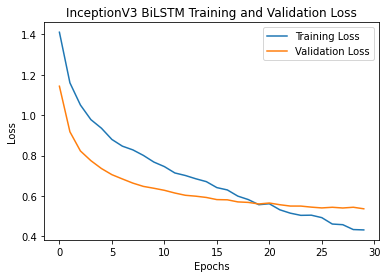

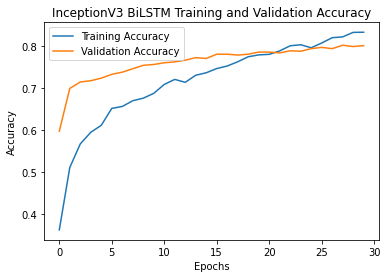

In [34]:
# Plot loss
plt.plot(history_inceptionv3.history['loss'], label='Training Loss')
plt.plot(history_inceptionv3.history['val_loss'], label='Validation Loss')
plt.title('InceptionV3 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_inceptionv3.history['acc'], label='Training Accuracy')
plt.plot(history_inceptionv3.history['val_acc'], label='Validation Accuracy')
plt.title('InceptionV3 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
train_score = model_inceptionv3.evaluate(train_batches, verbose=1)
test_score = model_inceptionv3.evaluate(test_batches, verbose=1)

123/123 [==============================] - 5s 41ms/step - loss: 0.5362 - acc: 0.8014


In [30]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
123/123 [==============================] - 7s 41ms/step

Classification Report InceptionV3 :
                      precision    recall  f1-score   support

bacterial_pneumonia    0.71905   0.73301   0.72596       206
            covid19    0.86473   0.84834   0.85646       211
             normal    0.82547   0.83732   0.83135       209
       tuberculosis    0.91852   0.88571   0.90182       140
    viral_pneumonia    0.72477   0.73148   0.72811       216

           accuracy                        0.80143       982
          macro avg    0.81051   0.80717   0.80874       982
       weighted avg    0.80270   0.80143   0.80198       982



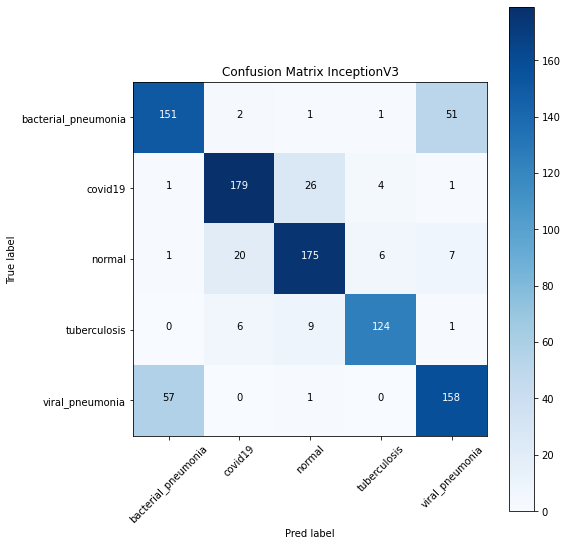

In [31]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_inceptionv3.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report InceptionV3 :\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix InceptionV3")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [32]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
380/380 [==============================] - 25s 66ms/step

Training Classification Report InceptionV3 :
                      precision    recall  f1-score   support

bacterial_pneumonia    0.86595   0.85246   0.85915      1220
            covid19    0.98401   0.89139   0.93542      1243
             normal    0.89039   0.96032   0.92404      1235
       tuberculosis    0.96774   0.97436   0.97104      1170
    viral_pneumonia    0.84956   0.87129   0.86029      1212

           accuracy                        0.90954      6080
          macro avg    0.91153   0.90996   0.90999      6080
       weighted avg    0.91137   0.90954   0.90968      6080



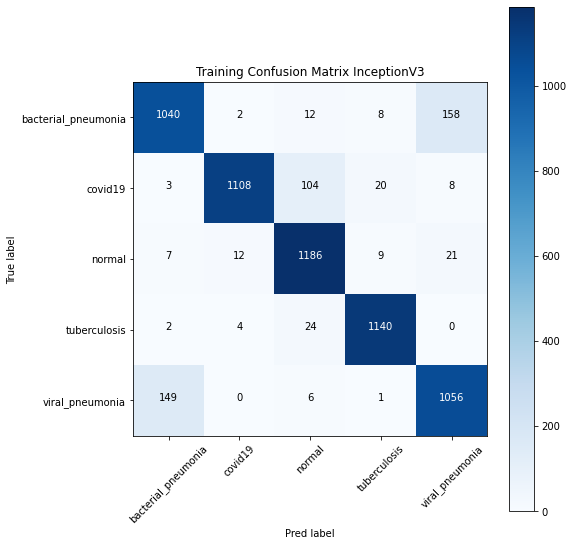

In [33]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_inceptionv3.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report InceptionV3 :\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix InceptionV3")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()